In [1]:
# 기본
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt

# 그래프 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

### 파일패스 설정 ⚠️ 이 부분 꼭 확인해서 설정한 뒤에 실행!!

In [2]:
data_type = "train"
month = "07"
category = "승인매출정보"

# local
root_path = '../data/open'

# colab
# root_path = '/content/drive/MyDrive/12조 파이널프로젝트/data'

drive_folder = f'{root_path}/{data_type}/3.승인매출정보/'

## 간단한 전처리만 한 버전 (1_전치리_단일데이터 에서 전처리한 파일 필요)

### 데이터 불러오기

In [3]:
#기본 전처리 데이터
file_name=f"{drive_folder}2018{month}_processed__{category}.csv"
df=pd.read_csv(file_name)

### XGBoost 활용해서 모델 학습 및 예측

In [6]:
# 1. 파일 불러오기
train_df = df  # 기존에 로딩된 train 데이터프레임
test_file =f"{drive_folder}2018{month}_processed__{category}.csv"
test_df = pd.read_csv(test_file)


🔷 타겟: Segment_A
✅ 예측 완료 → test_df[f'proba_Segment_A'] 생성됨


<Figure size 1000x600 with 0 Axes>

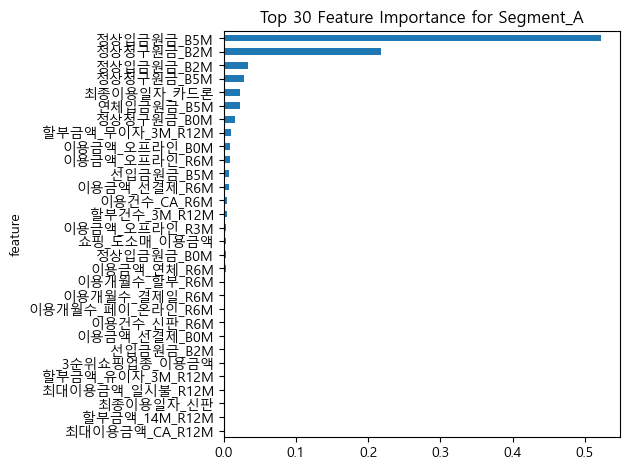


🔷 타겟: Segment_B
✅ 예측 완료 → test_df[f'proba_Segment_B'] 생성됨


<Figure size 1000x600 with 0 Axes>

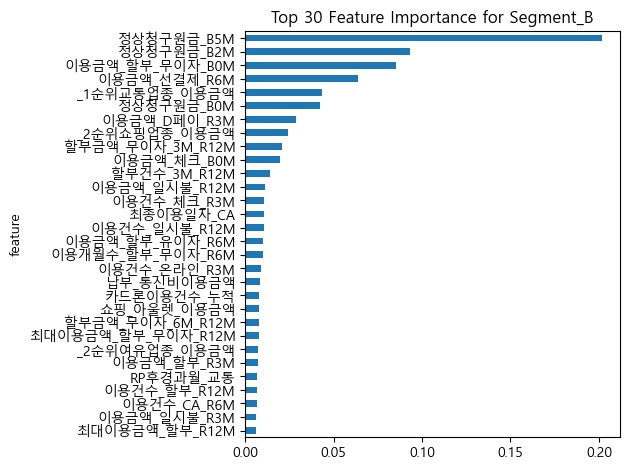


🔷 타겟: Segment_C
✅ 예측 완료 → test_df[f'proba_Segment_C'] 생성됨


<Figure size 1000x600 with 0 Axes>

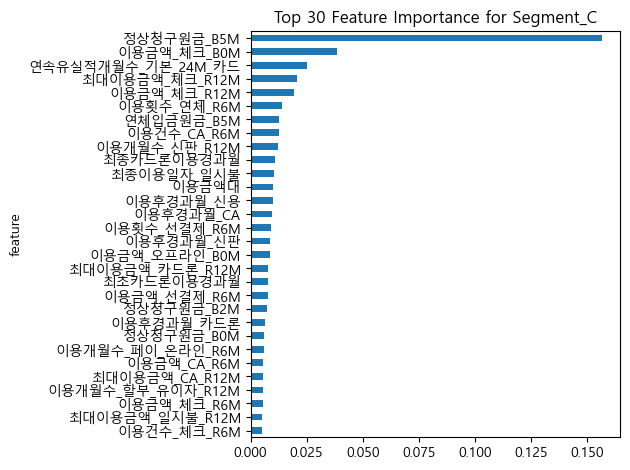


🔷 타겟: Segment_D
✅ 예측 완료 → test_df[f'proba_Segment_D'] 생성됨


<Figure size 1000x600 with 0 Axes>

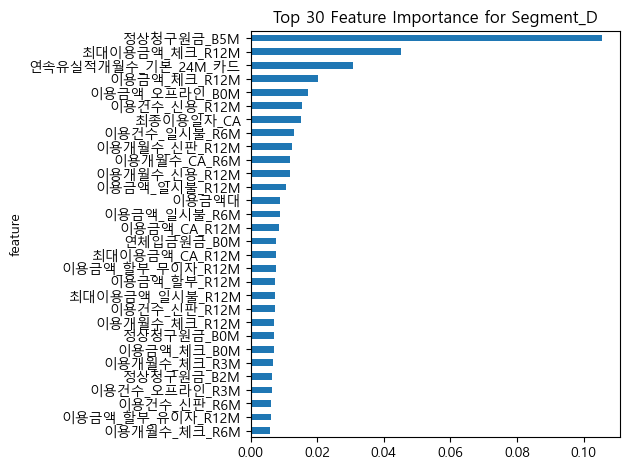


🔷 타겟: Segment_E
✅ 예측 완료 → test_df[f'proba_Segment_E'] 생성됨


<Figure size 1000x600 with 0 Axes>

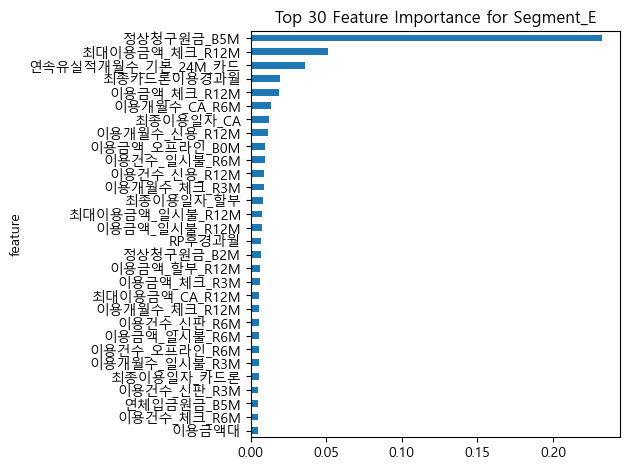

In [7]:
# 2. 공통 피처 추출용 설정
target_cols = ['Segment_A', 'Segment_B', 'Segment_C', 'Segment_D', 'Segment_E']
exclude_cols = ['ID', '기준년월'] + target_cols
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# 3. 결과 저장용
all_results = {}

for target in target_cols:
    print(f"\n🔷 타겟: {target}")
    
    # 학습 데이터
    X_train = train_df[feature_cols]
    y_train = train_df[target]
    
    # 테스트 데이터 (동일한 feature 컬럼만 사용)
    # 그 중 실제 test_df에 존재하는 컬럼만 추출
    valid_feature_cols = [col for col in feature_cols if col in test_df.columns]

    # 적용
    X_test = test_df[valid_feature_cols]
    
    # 1차 모델로 중요도 추출
    model_full = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model_full.fit(X_train, y_train)
    
    importance = model_full.feature_importances_
    importance_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importance
    }).sort_values(by='importance', ascending=False)
    
    # 상위 30개 피처 선택
    top_features = importance_df.head(30)['feature'].tolist()
    
    # 상위 피처만 추려서 다시 학습
    model_top = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model_top.fit(X_train[top_features], y_train)

    # 예측 확률 저장 (soft voting)
    y_proba = model_top.predict_proba(X_test[top_features])[:, 1]  # class 1 확률
    test_df[f'proba_{target}'] = y_proba

    print(f"✅ 예측 완료 → test_df[f'proba_{target}'] 생성됨")

    # 시각화
    plt.figure(figsize=(10, 6))
    importance_df.head(30).plot.barh(x='feature', y='importance', legend=False)
    plt.title(f"Top 30 Feature Importance for {target}")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    # 결과 저장
    all_results[target] = {
        'top_features': top_features,
        'importance_df': importance_df.head(30)
    }

In [8]:
# 1. 각 타겟별 예측값은 test_df['pred_Segment_X'] 에 저장되어 있다고 가정
segment_labels = ['A', 'B', 'C', 'D', 'E']
proba_cols = [f'proba_Segment_{label}' for label in segment_labels]

# 2. 각 row에서 확률이 가장 높은 컬럼의 label 선택
def get_top_segment(row):
    max_idx = row[proba_cols].values.argmax()
    return segment_labels[max_idx]

# 3. Segment 이름 붙이기
test_df['Segment'] = test_df.apply(get_top_segment, axis=1)

# 4. ID, Segment만 추출
submission = test_df[['ID', 'Segment']]

# 5. 저장
submission.to_csv('submission.csv', index=False)

print("✅ 예측 결과가 submission.csv 파일로 저장되었습니다.")

✅ 예측 결과가 submission.csv 파일로 저장되었습니다.
